In [3]:
from sklearn import datasets

# import some data to play with
X = datasets.load_iris(as_frame=True)['data']

2023-04-07 18:53:27,588 [5569] INFO     numexpr.utils: Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-04-07 18:53:27,589 [5569] INFO     numexpr.utils: NumExpr defaulting to 8 threads.


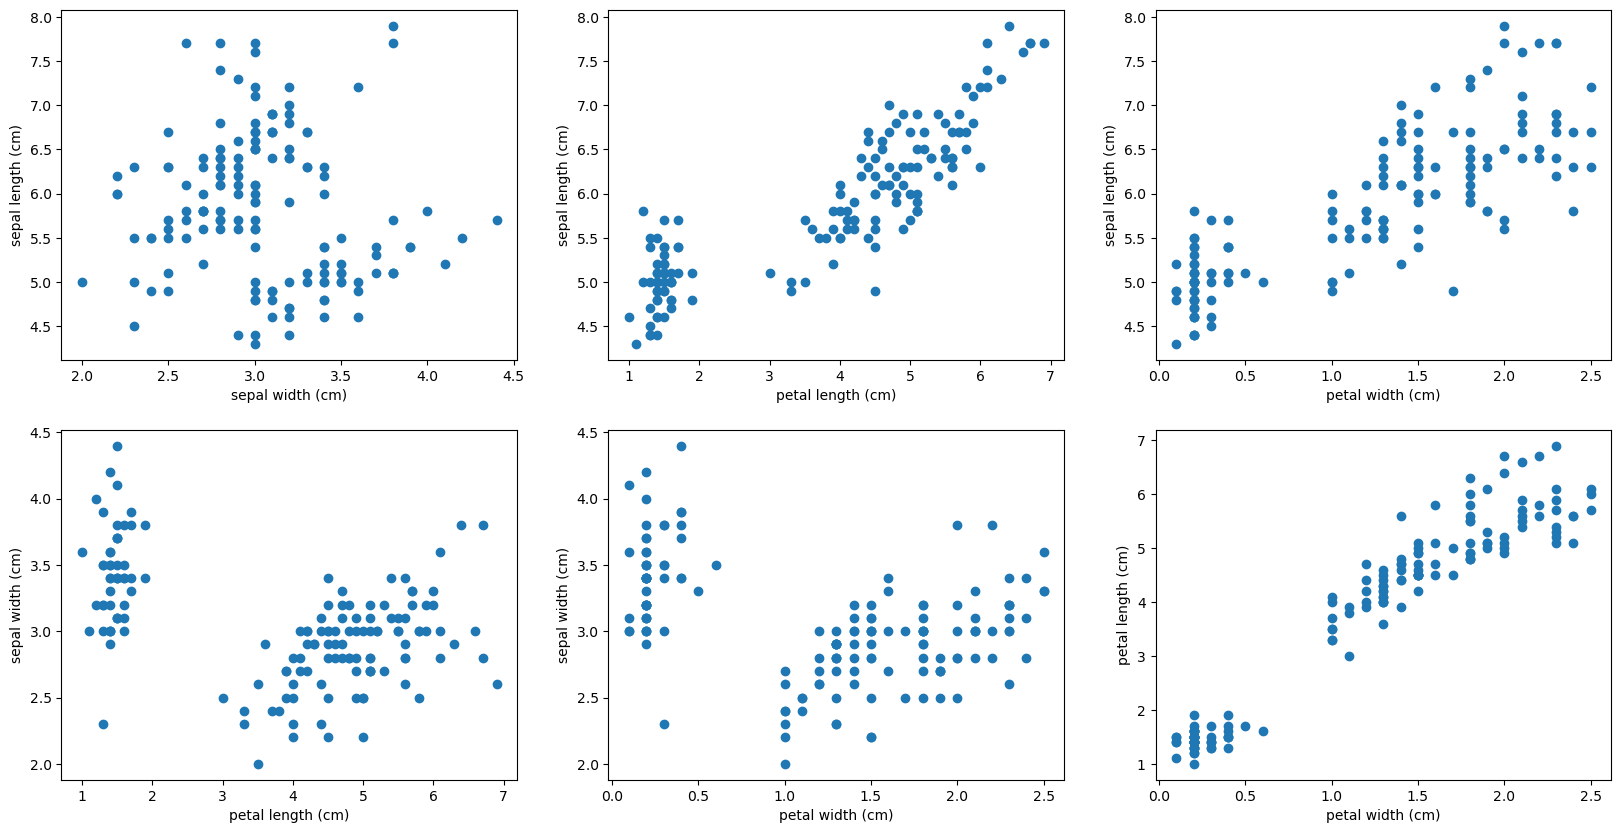

In [4]:
import matplotlib.pyplot as plt
n=1
plt.figure(figsize=(20,10))
from itertools import combinations
combinations_list = list(combinations(X.columns, 2))
v=3
for c in combinations_list:
    plt.subplot(len(combinations_list)//v,v,n)
    plt.scatter(x=X[c[1]],y=X[c[0]])
    plt.xlabel(c[1])
    plt.ylabel(c[0])
    n+=1
#plt.savefig('wine_eda.png')
plt.show()

### Example 1: Fit different  & measure K values

* Put the dataframe into `StandardScaler()` format
* Use a for loop to test values of `k` in `range(2,40)`
* At each iteration, fit `KMeans` and evaluate for `k`
    * Measure the sum of squared errors (aka 'Inertia')
    * Measure the silhouette coefficient for the clusters
    * Save each measure to a dictionary
* Print the dictionary into dataframe format

In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scores = {'sse':[],'silhouette':[]}

for k in range(2,40):
    model = KMeans(n_clusters=k,max_iter=100)
    model.fit(X_scaled)
    
    silhouette = silhouette_score(X_scaled,model.labels_,metric='euclidean')
    scores['sse'].append(model.inertia_)
    scores['silhouette'].append(silhouette)
    
pd.DataFrame(scores)

,sse,silhouette
0,222.361705,0.581750
1,139.820496,0.459948
2,114.304495,0.385174
3,90.927205,0.342363
4,81.706618,0.340576
5,71.942931,0.346563
6,62.510399,0.331447
7,54.459890,0.351225
8,47.643815,0.350487
9,42.761803,0.358065


### Example 2: Visualize the K means performance

Plot the `SSE` and `Silhouette` scores as a function of `K` using scatter plots. This will allow us to detect the 'elbow' to select the appropriate value of `K` for `Kmeans`.

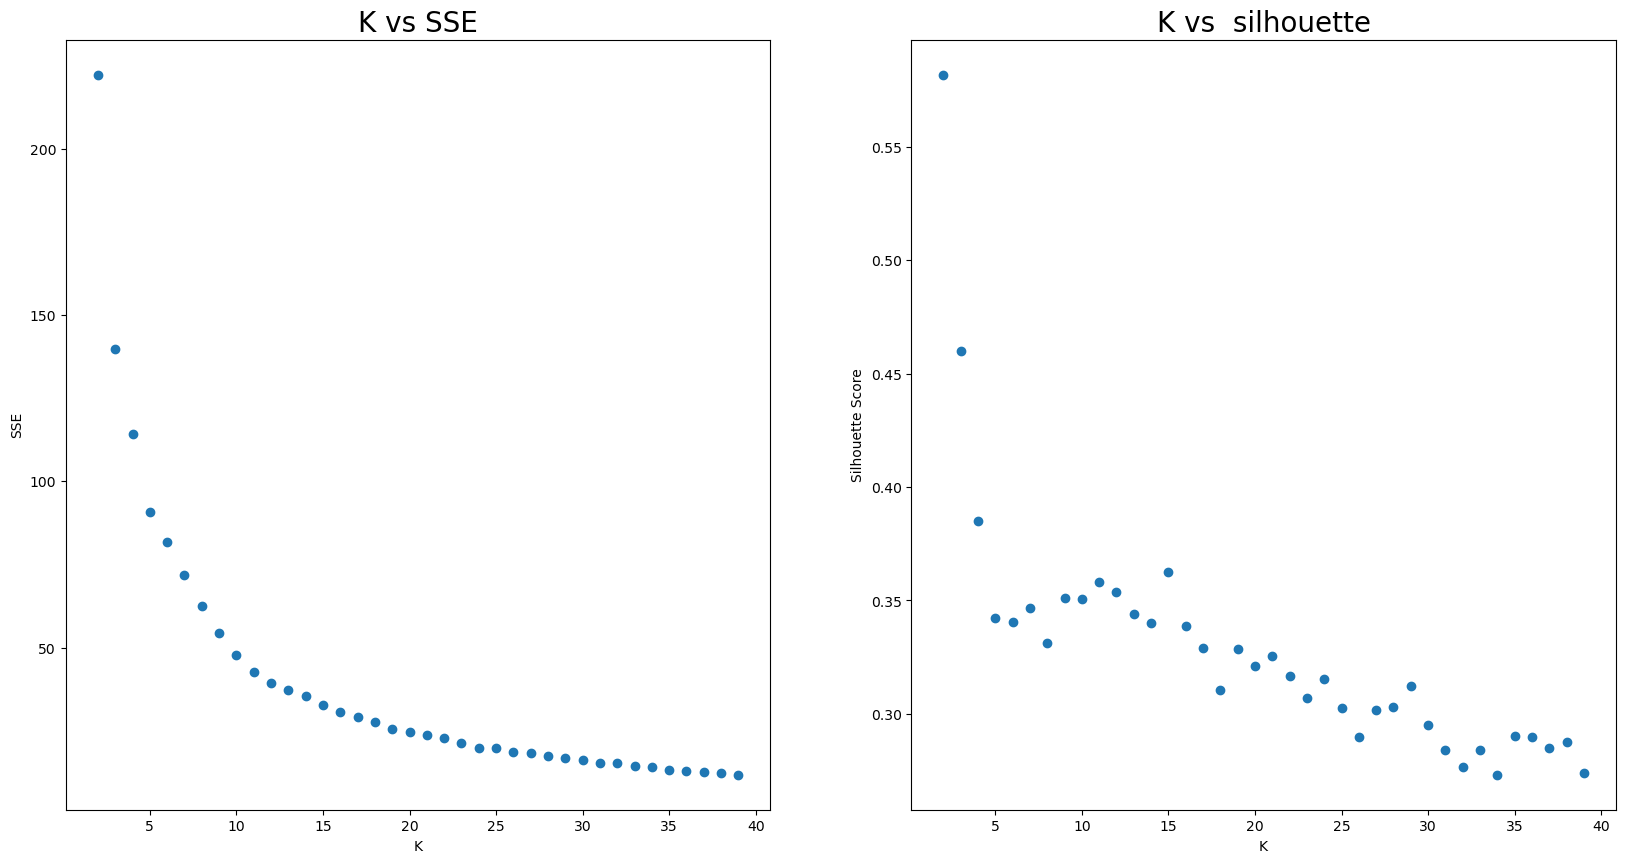

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(range(2,40),scores['sse'])
plt.title('K vs SSE',fontsize=20)
plt.xlabel('K')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.scatter(range(2,40),scores['silhouette'])
plt.title('K vs  silhouette',fontsize=20)
plt.ylabel('Silhouette Score')
plt.xlabel('K')
plt.show()

### Example 3: Use `KneeLocator` package to find `K`

Using the `kneed` package, the `sse` scores, find the optimal value of `k`. Then, using the plots from example 2 above, make a vertical bar with location of the optimal values of `k` for each metric.

* Add the value of the silhouette score for that k value to the plot

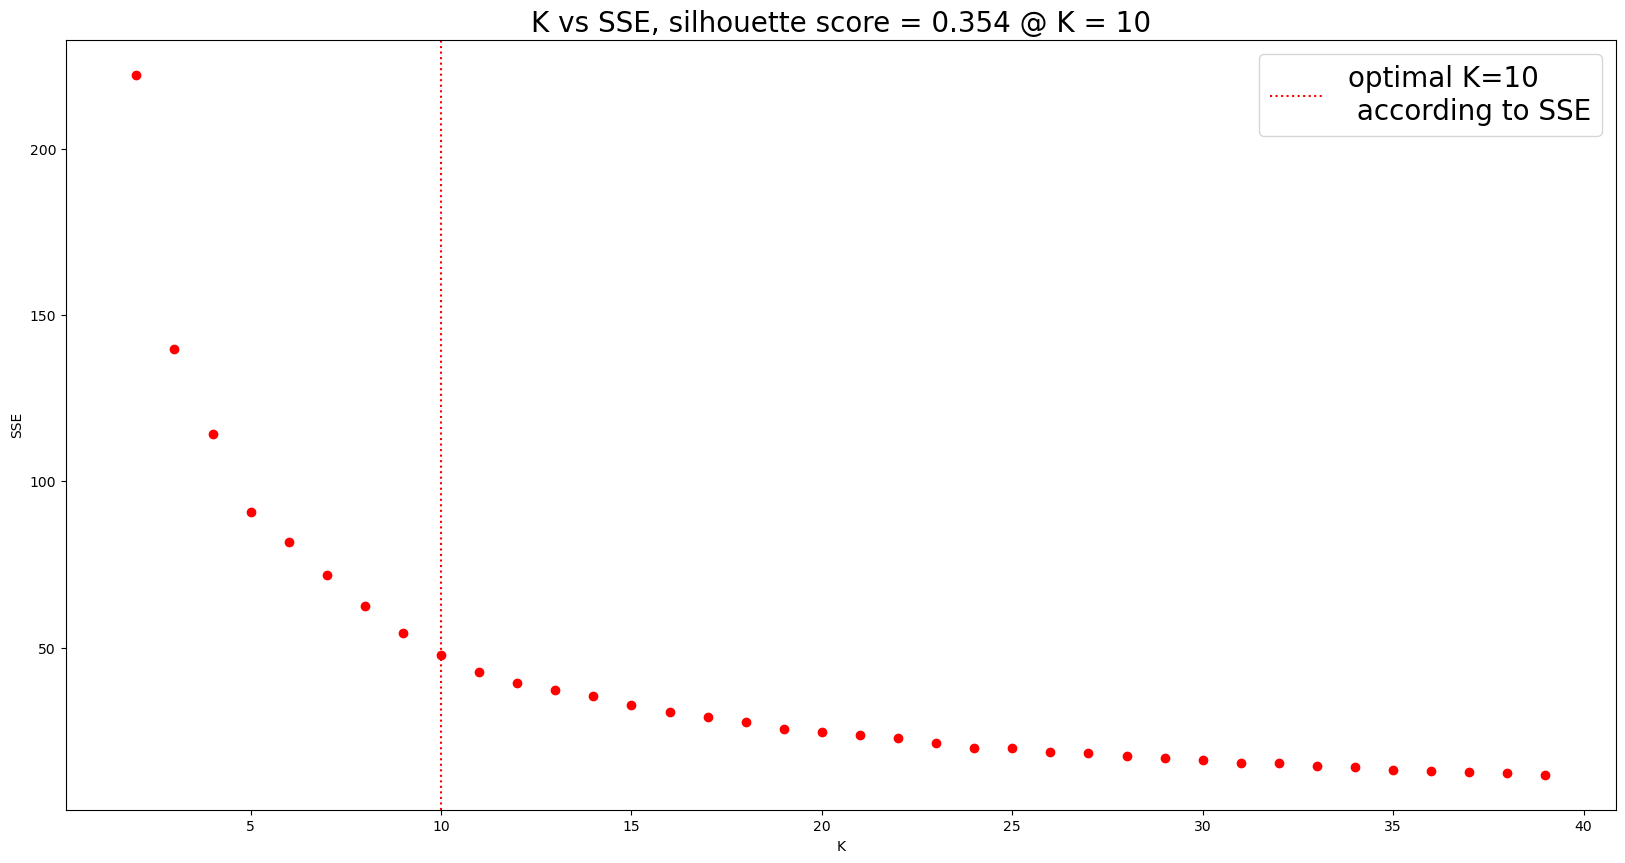

In [84]:
from kneed import KneeLocator

k_values = range(2,40)
knee_sse = KneeLocator(k_values,scores['sse'],curve='convex',direction='decreasing')
optimal_k_sse = knee_sse.knee


plt.figure(figsize=(20,10))
#plt.subplot(1,2,1)
plt.scatter(range(2,40),scores['sse'],c='r')
silh = round(scores['silhouette'][optimal_k_sse],3)
plt.axvline(optimal_k_sse,label='optimal K={} \n according to SSE'.format(optimal_k_sse),c='r',linestyle=':')
plt.title('K vs SSE, silhouette score = {} @ K = {}'.format(silh,optimal_k_sse),fontsize=20)
plt.xlabel('K')
plt.ylabel('SSE')
plt.legend(fontsize=20)
plt.show()

### Example 4: Silhouette plot for each cluster

K means will produce 9. seperate clusters, and each of these clusters will have their own silhouette score. Vertically plot these silhouette scores and compare them to the overall silhouette score.

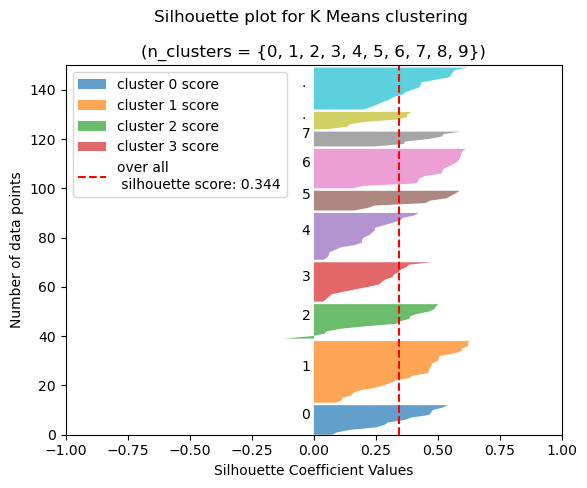

In [85]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
model = KMeans(n_clusters=optimal_k_sse,max_iter=100)
model.fit(X_scaled)
df = pd.DataFrame(X_scaled)
df['cluster'] = model.labels_
# Get the silhouette score for the entire dataset
silhouette = silhouette_score(df[df.columns[:-1]],df['cluster'],metric='euclidean')
silhouette_scores = silhouette_samples(df[df.columns[:-1]],df['cluster'],metric='euclidean')

# Plot the silhouette scores for each cluster
fig, ax = plt.subplots()
ax.set_xlim([-1, 1])
ax.set_ylim([0, len(X)])

y_lower = 0
for i in range(optimal_k_sse):
    cluster_silhouette_scores = silhouette_scores[model.labels_ == i]
    cluster_silhouette_scores.sort()
    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i
    if i<4:
        label = 'cluster {} score'.format(i)
    else:
        label = None
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none',label=label)
    if i<8:
        s = str(i)
    else:
        s = '.'
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, s)
    y_lower = y_upper

ax.set_title('''Silhouette plot for K Means clustering 
             \n(n_clusters = {})'''.format(set(model.labels_)))
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Number of data points")

ax.axvline(x=silhouette, color="red", linestyle="--",label='over all \n silhouette score: {}'.format(round(silhouette,4)))
plt.legend(loc='upper left')
plt.show()

### Example 5: Scatter Plot the clusters in 2D

In [75]:
clusters = pd.DataFrame(model.cluster_centers_)
clusters = pd.DataFrame(scaler.inverse_transform(clusters),columns=X.columns)
clusters

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.117647,2.723529,5.217647,1.870588
1,5.042857,3.461905,1.476190,0.271429
2,7.433333,2.922222,6.266667,1.988889
3,5.800000,2.855556,4.238889,1.311111
4,6.612500,3.175000,5.512500,2.256250
5,5.300000,2.438462,3.753846,1.169231
6,7.600000,3.733333,6.400000,2.233333
7,6.452632,3.057895,4.747368,1.552632
8,4.688235,3.035294,1.400000,0.194118
9,5.391667,3.925000,1.525000,0.275000


2023-04-06 22:22:47,070 [8398] WARNING  matplotlib.legend: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


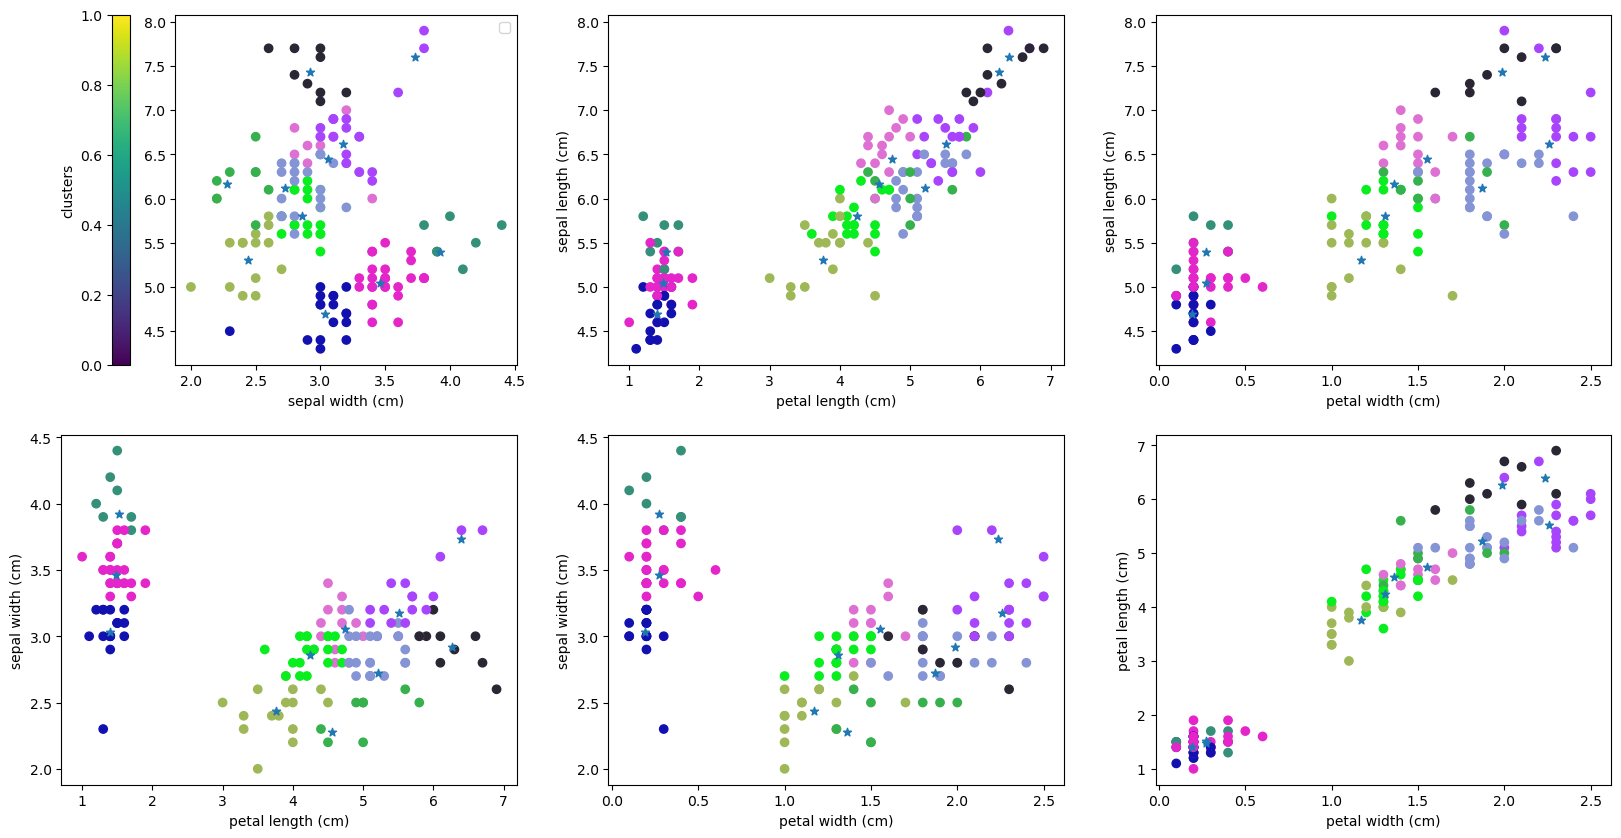

In [86]:
import matplotlib.pyplot as plt
n=1
plt.figure(figsize=(20,10))
from itertools import combinations
from matplotlib.colors import ListedColormap
combinations_list = list(combinations(X.columns, 2))
v=3
X['cluster'] = model.labels_
num_range = range(1, optimal_k_sse + 1)
color_range = np.random.rand(optimal_k_sse, 3)
# Define the range of discrete values for z
z_range = range(0, optimal_k_sse)
num_colors = len(z_range)
color_range = np.random.rand(num_colors, 3)
# Create a colormap that maps each z value to a unique color
cmap = ListedColormap(color_range)
v=3
n=1
for c in combinations_list:
    plt.subplot(len(combinations_list)//v,v,n)
    # Create the scatter plot
    x = X[c[1]]
    y = X[c[0]]
    z = X['cluster']
    plt.scatter(x, y, c=z, cmap=cmap)
    # Add a colorbar to the plot
    plt.scatter(x=clusters[c[1]],y=clusters[c[0]],marker='*',label=label)
    if n==1:
        plt.legend()
        cbar = plt.colorbar(location='left')
        cbar.set_label('clusters')
    if n!=1:
        plt.ylabel(c[0])
    plt.xlabel(c[1])
    n+=1
    if n>6:
        break
#plt.legend()
#plt.savefig('wine_eda.png')
plt.show()

### Example 4: What do conflicting metrics tells us?

In example 3, we see an optimal value of `k=9` according to the sum of squared errors `sse`. However, using the silhouette score we see an optimal value of `k=2`. These are off siginicantly.

* What does this tell us?
* What do we want our metrics to look like?
* What might we do to fix this?

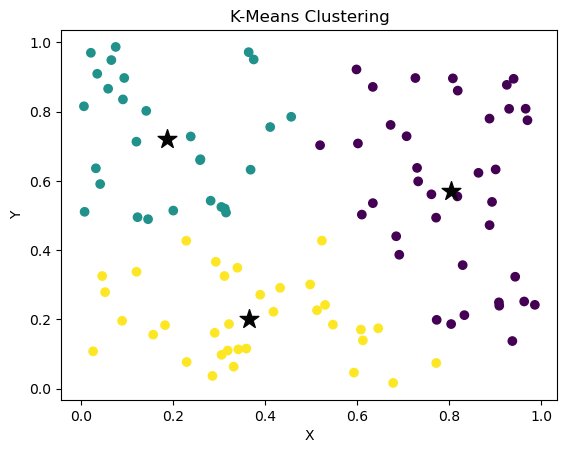

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate some random data points
np.random.seed(42)
X = np.random.rand(100, 2)

# Fit k-means to the data
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=200, c='#050505')
plt.title('K-Means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

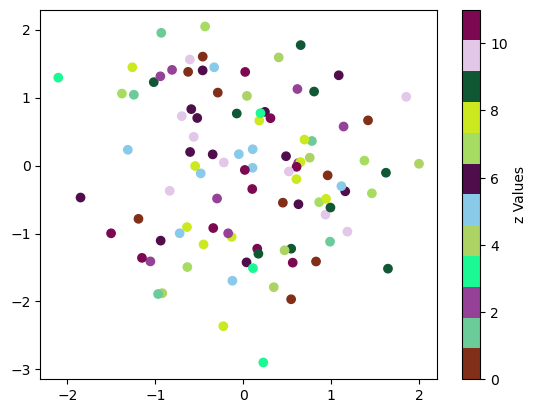

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Generate some example data
x = np.random.randn(100)
y = np.random.randn(100)
z = np.random.randint(0, 12, 100)

# Define the range of discrete values for z
z_range = range(0, 12)

# Generate a list of colors for each value of z
num_colors = len(z_range)
color_range = np.random.rand(num_colors, 3)

# Create a colormap that maps each z value to a unique color
cmap = ListedColormap(color_range)

# Create the scatter plot
plt.scatter(x, y, c=z, cmap=cmap)

# Add a colorbar to the plot
cbar = plt.colorbar()
cbar.set_label('z Values')

# Show the plot
plt.show()

In [56]:
len(color_range)

12